This notebook compares vanilla RNNs (SimpleRNN in keras) to an LSTM for the cartpole swingup

In [1]:
# Force keras to use the CPU becuase it's actually faster for this size network
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
os.environ["CUDA_VISIBLE_DEVICES"] = ''

import numpy as np
import pandas as pd

from numpy import cos, sin, pi
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.constraints import max_norm

from cartpole_class import Cartpole 

/Users/sgillen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## Define some constants

# Cartpole is a class we defined that takes care of the simulation/animation of the cartpole
bot = Cartpole()

# time vector, doesn't actually affect the integration, only what times it records our state variable at
dt = 0.1
time = np.arange(0.0, 20, dt)


In [3]:
## Run a bunch of trials using the energy shaping controller
# TODO: update this to the method I defined in misc/dimension_test

# parameters for the amount of different trajectories we generate with the energy shaping controller
num_trials = 1
num_states = 4
num_t = len(time)
y = np.zeros((num_t, num_states, num_trials))

for i in range(num_trials):
    # initial conditions
    theta = 0
    x = 0.0
    th_dot = 2*(i/num_trials) - 1 
    xdot = 0.0

    # initial state
    init_state = np.array([theta, x, th_dot, xdot])

    # integrate the ODE using scipy.integrate.
    # TODO switch over to the more modern solve_ivp, as we do for the pendubot
    u_hist = []
    y[:, :, i] = integrate.odeint(bot.derivs, init_state, time)


u = np.zeros((num_t, num_trials))

for i in range(num_trials):
    for t in range(num_t):
        u[t,i] = bot.control(y[t,:,i]) 

    

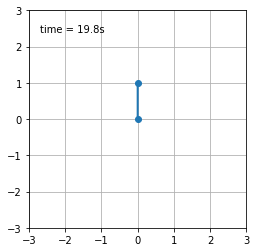

In [4]:
# Animate the cart (optional) 
ani = bot.animate_cart(time, y[:,:,0])
HTML(ani.to_jshtml())

In [5]:
# Create our two RNNs for comparison

look_back = 1

# Feed forward 
with tf.variable_scope('pi/simple_pol/'):
    ff_model = Sequential()
    #simple_model.add(SimpleRNN(12, input_shape=(4,look_back)))
    #model.add(LSTM(12, input_shape =(4,look_back)))
    ff_model.add(Dense(12, input_shape=(4,), activation ='relu'))
    ff_model.add(Dense(12, input_shape=(4,), activation ='relu'))
    ff_model.add(Dense(1))

    #model.add(Dense(2))

# LSTM
with tf.variable_scope('pi/simple_pol/'):
    lstm_model = Sequential()
    lstm_model.add(LSTM(12, input_shape =(4,look_back)))
    lstm_model.add(Dense(1))

    #model.add(Dense(2))
    

ff_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

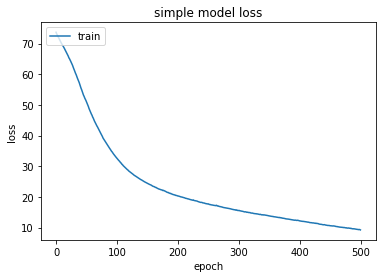

In [6]:
# Train Feedforward network

ff_history = ff_model.fit(y.squeeze(), u, epochs=500, verbose=0)
plt.plot(ff_history.history['loss'])
plt.title('simple model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.figure()

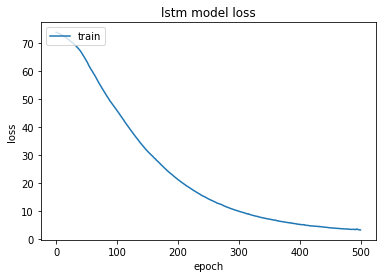

In [7]:
# Train LSTM

lstm_history = lstm_model.fit(y, u, epochs=500, verbose=0)
plt.plot(lstm_history.history['loss'])
plt.title('lstm model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [14]:
# This is a closure that returns our NN controller


def make_controller(model):
    def nn_controller(q):
        if (q[0] < (140 * (pi/180)) ) or (q[0] > (220 * (pi/180)) ):
            return model.predict(q.reshape((1,4,1)))
        else:
            # balancing
            # LQR: K values from MATLAB
            k1 = 140.560
            k2 = -3.162
            k3 = 41.772
            k4 = -8.314
            u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
            return u
        
    return nn_controller


# an ugly hack TODO make this and the one above compatible
def make_ff_controller(model):
    def nn_controller(q):
        if (q[0] < (140 * (pi/180)) ) or (q[0] > (220 * (pi/180)) ):
            return model.predict(q.reshape(1,4))
        else:
            # balancing
            # LQR: K values from MATLAB
            k1 = 140.560
            k2 = -3.162
            k3 = 41.772
            k4 = -8.314
            u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
            return u
        
    return nn_controller



ff_control = make_ff_controller(ff_model)
lstm_control = make_controller(lstm_model)

ff_bot = Cartpole()
lstm_bot = Cartpole()

ff_bot.control = ff_control
lstm_bot.control = lstm_control

# initial conditions
theta = .4
x = 1
th_dot = .1 # an initial velocity, triggers the swing up control
xdot = 0.1
time = np.arange(0.0, 20, dt)

# initial state
init_state = np.array([theta, x, th_dot, xdot])

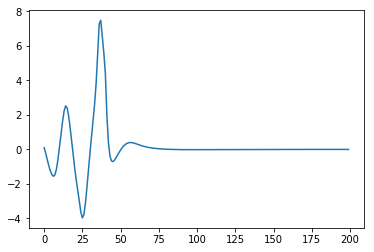

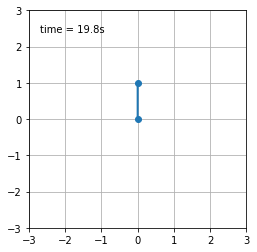

In [15]:
# Run the simulation for the feedforward network

# Fill in our u after the fact..
y_ff = integrate.odeint(ff_bot.derivs, init_state, time)
u_ff = np.zeros((y.shape[0],1))

for t in range(num_t):
        u_ff[t] = ff_bot.control(y[t]) 

plt.figure()
plt.plot(y_ff[:,2])

ani = ff_bot.animate_cart(time, y_ff)
HTML(ani.to_jshtml())

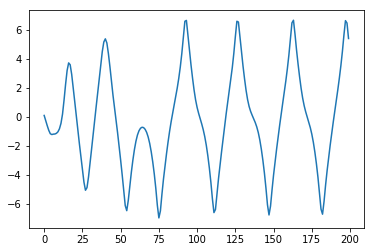

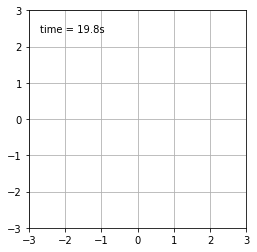

In [17]:
# Run the simulation for the RNN

# integrate the ODE using scipy.integrate.
# Fill in our u after the fact..
y_lstm = integrate.odeint(lstm_bot.derivs, init_state, time)
u_lstm = np.zeros((y.shape[0],1))
for t in range(num_t):
        u_lstm[t] = lstm_bot.control(y[t]) 
   

plt.figure()
plt.plot(y_lstm[:,2])



ani = lstm_bot.animate_cart(time, y_lstm)
HTML(ani.to_jshtml())